In [1]:
import torch as th
import torch
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt
import math
from functools import reduce

In [65]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim):
        # In the new version grad will be separate, so image gradients will not be here
        # Normal initialization of Snake super class
        self.graph_structure = graph
        super().__init__(graph, crop, stepsz, alpha, beta, dim)
        # Additionally we sample from a normal distrubution for widths of nodes
        #self.w = torch.randn(self.s.shape[0]).abs()
        self.w = torch.ones(self.s.shape[0])

    def cuda(self):
        super().cuda()
        # move the widths to gpu
        self.w = self.w.cuda()

    def set_w(self, widths):
        self.w = widths

    def get_w(self):
        return self.w

    def _compute_normals(self, pos):
        """
        Compute normals (and tangents for 3D) for each center point.
        Returns:
         - 2D: (normals,) where normals is (N,2)
         - 3D: (n1, n2, tangents) each (N,3)
        """
        N, d = pos.shape
        eps = 1e-8
        t = torch.zeros_like(pos)
        if N > 1:
            t[1:-1] = (pos[2:] - pos[:-2]) * 0.5
            t[0] = pos[1] - pos[0]
            t[-1] = pos[-1] - pos[-2]
        t = t / (t.norm(dim=1, keepdim=True) + eps)

        if self.ndims == 2:
            normals = torch.stack([-t[:,1], t[:,0]], dim=1)
            normals = normals / (normals.norm(dim=1, keepdim=True) + eps)
            return (normals,)
        else:
            a = torch.zeros_like(pos)
            a[:] = torch.tensor([1.0, 0.0, 0.0])
            mask = (t * a).abs().sum(dim=1) > 0.9
            a[mask] = torch.tensor([0.0, 1.0, 0.0])
            n1 = torch.cross(t, a, dim=1)
            n1 = n1 / (n1.norm(dim=1, keepdim=True) + eps)
            n2 = torch.cross(t, n1, dim=1)
            n2 = n2 / (n2.norm(dim=1, keepdim=True) + eps)
            return (n1, n2, t)
        
    def comp_second_deriv(self):
        """
        1D second-derivative smoothing for widths via convolution.
        """
        w = self.w.view(1, 1, -1)
        kernel = torch.tensor([1.0, -4.0, 6.0, -4.0, 1.0], device=w.device).view(1,1,5)
        grad_norm = F.conv1d(w, kernel, padding=2)
        return grad_norm.view(-1,1)
    
    def step_widths(self, gimgW):
        """
        Update widths by sampling gradient of image W at ribbon edges and
        adding internal smoothness via second derivative.
        """
        if self.s.numel() == 0:
            return self.w

        pos = self.s                  # (N, d)
        K, d = pos.shape
        device = pos.device
        half_r = self.w * 0.5 # N

        if d == 2:
            (normals,) = self._compute_normals(pos)
            left_pts  = pos - normals * half_r.unsqueeze(1)
            right_pts = pos + normals * half_r.unsqueeze(1)

            grad_L = cmptExtGrad(left_pts,  gimgW)
            grad_R = cmptExtGrad(right_pts, gimgW)
            # radial derivative
            grad_w = ((grad_R - grad_L) * normals).sum(dim=1, keepdim=True)

        else:  # d == 3
            n1, n2, _ = self._compute_normals(pos)   # each (K,3)

            N = 8
            theta = torch.linspace(0, 2*math.pi, N, device=device, dtype=pos.dtype)[:-1]  # (N-1,)
            dirs = (
                theta.cos().unsqueeze(1).unsqueeze(2) * n1.unsqueeze(0) +
                theta.sin().unsqueeze(1).unsqueeze(2) * n2.unsqueeze(0)
            )  # (N-1, K, 3)

            pts_out = pos.unsqueeze(0) + half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            pts_in = pos.unsqueeze(0) - half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            all_pts = torch.cat([pts_out, pts_in], dim=0) # (2(N-1), K, 3)

            grads = cmptExtGrad(all_pts.view(-1,3), gimgW)# (2(N-1)*K, 3)
            grads = grads.view(2*(N-1), -1,3)

            grad_diff = grads[:(N-1)] - grads[(N-1):] # (N-1, K, 3)
            radial = (grad_diff * dirs).sum(dim=2) # (N-1, K)
            grad_w = radial.mean(dim=0, keepdim=True).t() # (K,1)
            norm_grad = self.comp_second_deriv() # (K,1)
            w_flat    = self.w.view(-1) # (K,)
            smooth    = torch.zeros_like(w_flat) # (K,)

            if K > 1:
                smooth[0]   = w_flat[0]   - w_flat[1]
                smooth[-1]  = w_flat[-1]  - w_flat[-2]
                if K > 2:
                    smooth[1:-1] = 2*w_flat[1:-1] - w_flat[:-2] - w_flat[2:]

            smooth = smooth.view(K,1) # (K,1)
            internal = norm_grad + smooth # (K,1)
            alpha = grad_w.abs() / (internal.abs() + 1e-8)
            total = grad_w + alpha * internal # (K,1)
            self.w = self.w - self.stepsz * total.squeeze(1)
            return self.w

        # internal smoothness
        internal = self.comp_second_deriv()
        alpha = grad_w.abs() / (internal.abs() + 1e-8)
        total = (grad_w + alpha * internal).squeeze(1)
        # gradient step
        self.w = self.w - self.stepsz * total
        return self.w
    
    """ def render_distance_map_with_widths(self, size):
        device = self.s.device
        centers = self.s
        radii   = (self.w.flatten() / 2)
        axes    = [torch.arange(sz, device=device, dtype=torch.float32) for sz in size]
        mesh    = torch.meshgrid(*axes, indexing='ij')
        points  = torch.stack([m.flatten() for m in mesh], dim=1)

        # capsule sides
        if centers.shape[0] > 1:
            starts, ends = centers[:-1], centers[1:]
            r0, r1 = radii[:-1], radii[1:]
            vec = ends - starts
            L   = vec.norm(dim=1, keepdim=True)
            D   = vec / (L + 1e-8)

            P = points.unsqueeze(1)
            S = starts.unsqueeze(0)
            D = D.unsqueeze(0)
            L = L.unsqueeze(0).squeeze(-1)

            v    = P - S
            proj = (v * D).sum(dim=2)
            # clamp proj to [0, L]
            low  = proj.clamp(min=0.0)
            t    = torch.min(low, L)

            closest       = S + D * t.unsqueeze(-1)
            dist_axis     = (P - closest).norm(dim=2)
            frac          = t / (L + 1e-8)
            interp_radius = r0 * (1-frac) + r1 * frac
            dist_capsule, _ = (dist_axis - interp_radius).min(dim=1)
        else:
            dist_capsule = torch.full((points.shape[0],), float('inf'), device=device)

        # end caps
        start_c = centers[0]; end_c = centers[-1]
        dist_start = (points - start_c).norm(dim=1) - radii[0]
        dist_end   = (points - end_c).norm(dim=1)   - radii[-1]

        dist = torch.min(dist_capsule, dist_start)
        dist = torch.min(dist, dist_end)
        #dist.requires_grad_(True)
        return torch.clamp(dist.reshape(*size), max=16) """
    def render_distance_map_with_widths(self, size):
        """
        Unified 2D/3D signed distance map for the ribbon snake. Relies on accurate
        graph structure and node indexing provided during initialization.

        Args:
            size (tuple): Grid dimensions (e.g., (W, H) or (X, Y, Z)).

        Returns:
            torch.Tensor: Signed distance map of shape `size`, clamped max=16.0.
        """
        num_nodes = self.s.shape[0]
        if num_nodes == 0:
            return torch.full(size, 16.0)

        centers = self.s
        # Ensure radii are positive, use stored dtype/device
        radii = (self.w.flatten() / 2).clamp(min=1e-6)

        # --- Grid Generation ---
        axes = [torch.arange(sz) for sz in size]
        mesh = torch.meshgrid(*axes, indexing='ij')
        points = torch.stack([m.flatten() for m in mesh], dim=1)
        num_points = points.shape[0]

        # Initialize minimum distance to positive infinity
        min_dist = torch.full((num_points,), float('inf'))

        # --- Edge/Capsule Calculation ---
        edge_indices = torch.empty((0, 2), dtype=torch.long)
        num_edges_retrieved = 0
        try:
            # Retrieve edge list from the stored graph structure
            edge_list = list(self.graph_structure.edges)
            num_edges_retrieved = len(edge_list)
            if num_edges_retrieved > 0:
                 edge_indices = torch.tensor(edge_list, dtype=torch.long)
        except Exception as e:
             print(f"Warning: Failed to retrieve edges from self.graph_structure: {e}")

        num_valid_segments = 0
        if num_edges_retrieved > 0:
            u_indices, v_indices = edge_indices[:, 0], edge_indices[:, 1]

            # 1. Validate Indices are within bounds
            valid_idx_mask = (u_indices >= 0) & (u_indices < num_nodes) & \
                             (v_indices >= 0) & (v_indices < num_nodes)
            # 2. Exclude Self-loops
            non_self_loop_mask = (u_indices != v_indices)

            combined_mask = valid_idx_mask & non_self_loop_mask
            num_edges_after_basic_filt = combined_mask.sum().item()

            if num_edges_after_basic_filt < num_edges_retrieved:
                 # Optional warning if edges were filtered here
                 # print(f"Info: Filtered {num_edges_retrieved - num_edges_after_basic_filt} edges due to out-of-bounds indices or self-loops.")
                 pass

            if num_edges_after_basic_filt > 0:
                u_indices = u_indices[combined_mask]
                v_indices = v_indices[combined_mask]

                starts = centers[u_indices]
                ends = centers[v_indices]
                r0 = radii[u_indices]
                r1 = radii[v_indices]

                vec = ends - starts
                L_sq = vec.pow(2).sum(dim=1)

                # 3. Filter Zero-Length Segments (points are coincident)
                # Increased epsilon slightly for float robustness
                valid_segment_mask = L_sq > 1e-9
                num_valid_segments = valid_segment_mask.sum().item()

                if num_valid_segments < num_edges_after_basic_filt:
                     # Optional warning if segments were filtered here
                     # print(f"Info: Filtered {num_edges_after_basic_filt - num_valid_segments} edges due to zero length (coincident start/end nodes).")
                     pass

                if num_valid_segments > 0:
                    # --- Select only valid segments for SDF calculation ---
                    starts_f = starts[valid_segment_mask]
                    vec_f = vec[valid_segment_mask]
                    L_norm_f = torch.sqrt(L_sq[valid_segment_mask])
                    r0_f = r0[valid_segment_mask]
                    r1_f = r1[valid_segment_mask]
                    # --- End Selection ---

                    # --- Capsule SDF Calculation (Vectorized) ---
                    P = points.unsqueeze(1) # (N_pts, 1, d)
                    S = starts_f.unsqueeze(0) # (1, N_seg, d)
                    V = vec_f.unsqueeze(0)    # (1, N_seg, d)
                    L = L_norm_f.unsqueeze(0) # (1, N_seg)

                    D = V / (L.unsqueeze(-1) + 1e-10) # Normalized dir (1, N_seg, d)
                    v_PS = P - S # (N_pts, N_seg, d)

                    t = (v_PS * D).sum(dim=2).clamp_(min=0.0) # Project: dot(P-S, Dir)
                    t = torch.min(t, L)                      # Clamp t to [0, L]

                    closest_on_axis = S + D * t.unsqueeze(-1) # (N_pts, N_seg, d)
                    dist_axis = (P - closest_on_axis).norm(dim=2) # (N_pts, N_seg)

                    frac = t / (L + 1e-10) # Interpolation fraction
                    r0_exp = r0_f.unsqueeze(0) # (1, N_seg)
                    r1_exp = r1_f.unsqueeze(0) # (1, N_seg)
                    interp_radius = r0_exp * (1 - frac) + r1_exp * frac # (N_pts, N_seg)

                    dist_capsules_all = dist_axis - interp_radius # SDF for all capsules (N_pts, N_seg)
                    dist_capsules, _ = dist_capsules_all.min(dim=1) # Min dist across capsules (N_pts,)

                    # Update overall minimum distance found so far
                    min_dist = torch.minimum(min_dist, dist_capsules)
                    # --- End Capsule SDF ---

        # --- Fallback / Finalization ---
        # If NO valid segments were processed (either no edges retrieved, all filtered,
        # or all had zero length), AND there are nodes, calculate distance to nodes.
        if num_valid_segments == 0 and num_nodes > 0:
             # print("Info: No valid capsule segments found. Calculating distance based on node spheres.") # Optional info
             dist_to_centers = torch.cdist(points, centers) # (N_pts, N)
             dist_nodes_all = dist_to_centers - radii.unsqueeze(0) # (N_pts, N)
             dist_nodes, _ = dist_nodes_all.min(dim=1) # (N_pts,)
             # Since min_dist is still inf (because no capsules were processed), assign node distances
             min_dist = dist_nodes

        # Ensure no inf values remain (paranoid check)
        min_dist[torch.isinf(min_dist)] = 16.0

        # Reshape to the original grid size and clamp the maximum distance
        dist_map = min_dist.reshape(*size)
        return torch.clamp(dist_map, max=16.0)

In [59]:
def makeGaussEdgeFltr(stdev,d):
    # make a Gaussian-derivative-based edge filter
    # filter size is determined automatically based on stdev
    # the filter is ready to be used with pytorch conv 
    # input params:
    #   stdev - the standard deviation of the Gaussian
    #   d - number of dimensions
    # output:
    #   fltr, a np.array of size d X 1 X k X k,
    #         where k is an odd number close to 4*stdev
    #         fltr[i] contains a filter sensitive to gradients
    #         along the i-th dimension

    fsz=round(2*stdev)*2+1 # filter size - make the it odd

    n=np.arange(0,fsz).astype(float)-(fsz-1)/2.0
    s2=stdev*stdev
    v=np.exp(-n**2/(2*s2)) # a Gaussian
    g=n/s2*v # negative Gaussian derivative

    # create filter sensitive to edges along dim0
    # by outer product of vectors
    shps = np.eye(d,dtype=int)*(fsz-1)+1
    reshaped = [x.reshape(y) for x,y in zip([g]+[v]*(d-1), shps)]
    fltr=reduce(np.multiply,reshaped)
    fltr=fltr/np.sum(np.abs(fltr))
    
    # add the out_channel, in_channel initial dimensions
    fltr_=fltr[np.newaxis,np.newaxis]
    # transpose the filter to be sensitive to edges in all directions 
    fltr_multidir=np.concatenate([np.moveaxis(fltr_,2,k) for k in range(2,2+d)],axis=0)
    
    return fltr_multidir

def cmptGradIm(img,fltr):
    # convolves img with fltr, with replication padding
    # fltr is assumed to be of odd size
    # img  is either 2D: batch X channel X height X width
    #             or 3D: batch X channel X height X width X depth
    #      it is a torch tensor
    # fltr is either 2D: 2 X 1 X k X k
    #             or 3D: 3 X 1 X k X k X k
    #      it is a torch tensor
    
    if img.dim()==4:
        img_p=torch.nn.ReplicationPad2d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv2d(img_p,fltr)
    if img.dim()==5:
        img_p=torch.nn.ReplicationPad3d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv3d(img_p,fltr)
    else:
        raise ValueError("img should have 4 or 5 dimensions")

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)

class GradImRib(RibbonSnake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim, gimgV, gimgW):
        super().__init__(graph, crop, stepsz, alpha, beta, dim)

        self.gimgV = gimgV
        self.gimgW = gimgW
    
    def cuda(self):
        super().cuda()
        if self.gimgV is not None:
            self.gimgV = self.gimgV.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()

    def step(self):
        return super().step(cmptExtGrad(self.s, self.gimgV))
    
    def step_widths(self):
        return super().step_widths(self.gimgW)
    
    def optim(self, niter):
        if len(self.s) > 0:
            for i in range(niter):
                if i < niter / 2:
                    self.step()
                else:
                    self.step_widths()
        return self.s

In [60]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

In [61]:
def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.show()

# With Loss

In [62]:
import torch.nn as nn
import torch.optim as optim

In [66]:
class SnakeFastLoss(nn.Module):
    def __init__(self, stepsz, alpha, beta, fltrstdev, ndims, nsteps,
                 cropsz, dmax, maxedgelen, extgradfac):
        super(SnakeFastLoss, self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev, self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(SnakeFastLoss, self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self, pred_dmap, lbl_graphs, crops=None, ind= None):
        # pred_dmap is the predicted distance map from the UNet
        # lbl_graphs contains graphs each represent a label as a snake
        # crops is a list of slices, each represents the crop area of the corresponding snake

        pred_ = pred_dmap
        gimg = cmptGradIm(pred_.detach(), self.fltrt)
        gimg *= self.extgradfac
        snake_dmap = []

        # Get the output dimensions from pred_dmap
        output_size = pred_dmap.shape[2:]
        device = pred_dmap.device

        for i, lg in enumerate(zip(lbl_graphs, gimg)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0]  # graph
            g = lg[1]  # gradient image

            if crops:
                crop = crops[i]
            else:
                crop = [slice(0, s) for s in g.shape[1:]]

            gimgW = torch.abs(g).clone()
            s = GradImRib(graph=l, crop=crop, stepsz=self.stepsz, alpha=self.alpha,
                        beta=self.beta,dim=self.ndims, gimgV=g, gimgW=gimgW)
                    
            if self.iscuda: 
                s.cuda()

            s.optim(self.nsteps)
            dmap = s.render_distance_map_with_widths(g[0].shape)
            if dmap.shape != output_size:
                dmap = torch.nn.functional.interpolate(
                    dmap.unsqueeze(0).unsqueeze(0),
                    size=output_size,
                    mode='nearest'
                ).squeeze(0).squeeze(0)
                
            dmap = dmap.to(device)
            snake_dmap.append(dmap)

        snake_dm = torch.stack(snake_dmap, 0).unsqueeze(1)   
        snake_dm = snake_dm.to(device)     
        loss = ((pred_dmap - snake_dm)**2).sum() / 100
        self.snake = s
        return loss

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_8169/2774615746.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


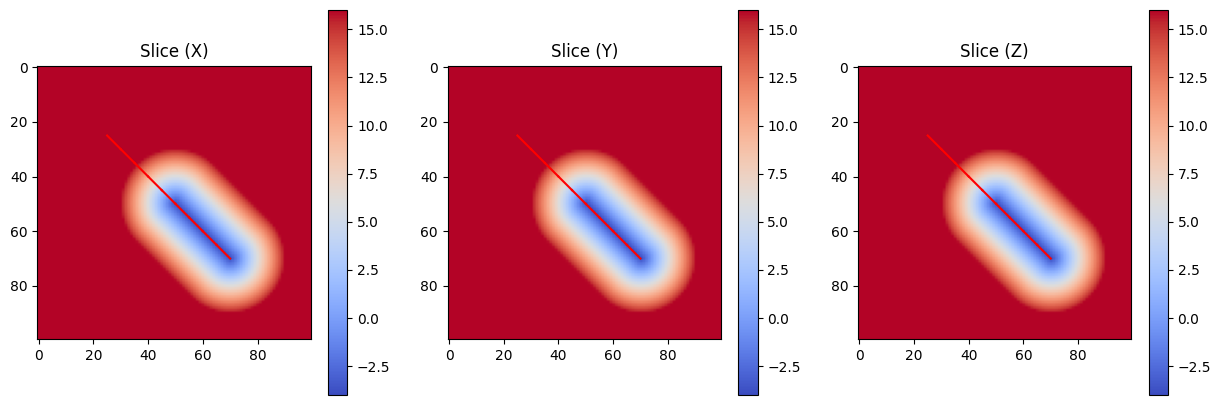

In [67]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [40]:
pred_initial2[:,:,33:34,:,:] = 16.0
pss = pred_initial2[0][0]

In [41]:
pss.shape

torch.Size([100, 100, 100])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_8169/2399199909.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pss), g)


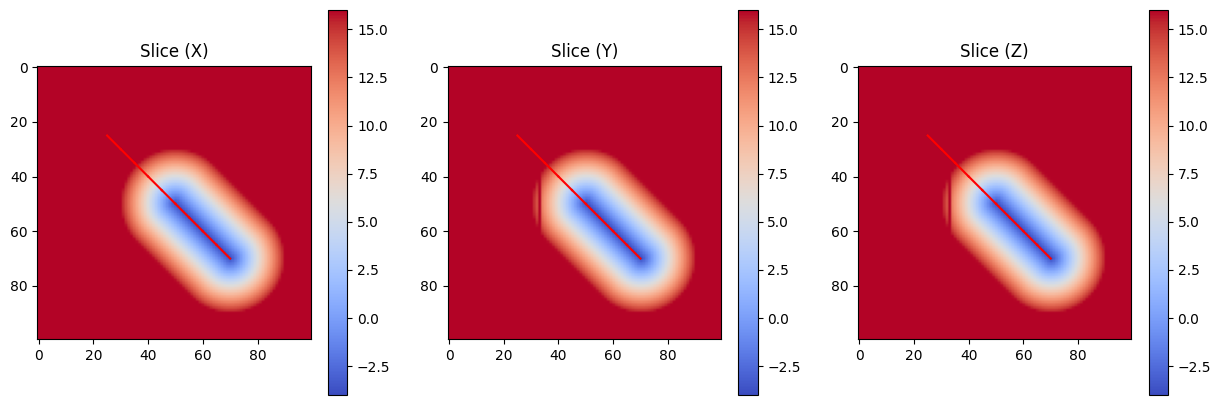

In [42]:
show_slices(np.array(pss), g)

In [ ]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 1
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect.detach()), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34,:] = 10.0

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2 = nn.Parameter(pred_initial2.clone(), requires_grad=True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10,0]) 

show_slices(np.array(pred_initial2[0][0].detach()), g)

fltrstdev=1.0

opt = optim.SGD([pred2], lr=15.0, momentum=0.0)

extgradfac=1.0
nsteps=60
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                crop,16,4,extgradfac)

for i in range(1000):
    opt.zero_grad()
    loss_val = loss(pred2, [g])
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 500 == 0:
        show_slices(np.array(pred2.clone().detach()[0][0]), loss.snake.getGraph())

show_slices(pred2.detach().cpu().numpy()[0, 0], g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show_slices(np.array(final_pred[0][0]), loss.snake.getGraph())

In [29]:
loss.snake.get_w()

tensor([-0.1390, -0.1510, -0.0563,  0.0234,  0.0906,  0.1075,  0.0899,  0.0079,
        -0.0637, -0.0723])

# 2d

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_8169/731961966.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect), "2D", g)


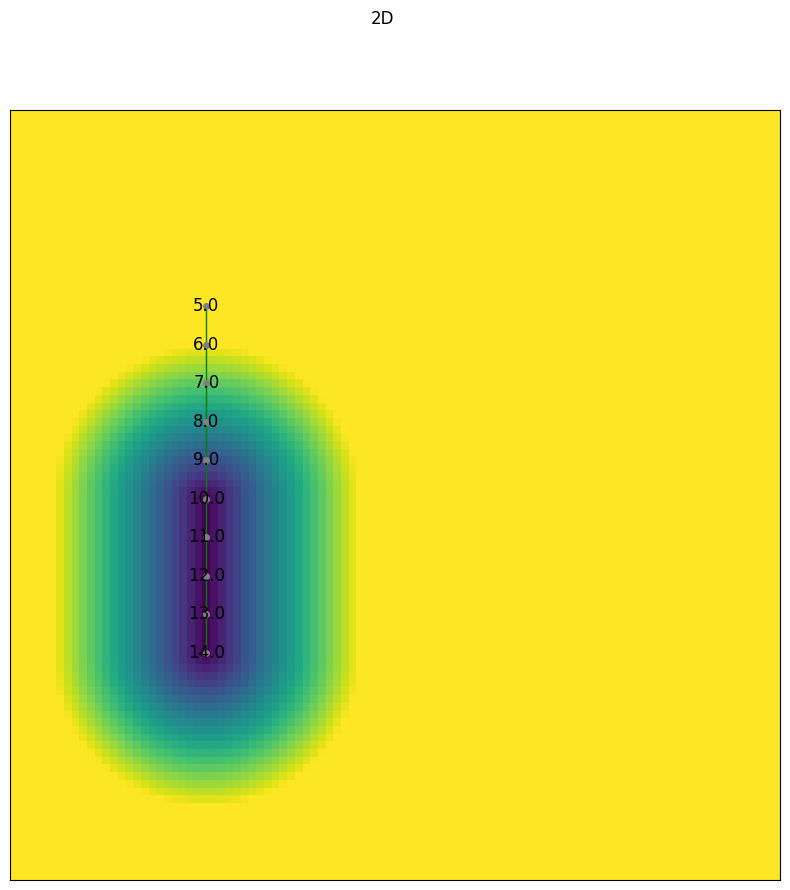

In [43]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect), "2D", g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [192]:
pred_initial2[:,:,:,33:34] = 16.0
pss = pred_initial2[0][0]

In [193]:
pss.shape

torch.Size([100, 100])

C:\Users\serta\AppData\Local\Temp\ipykernel_13332\1881745071.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pss), "", g)


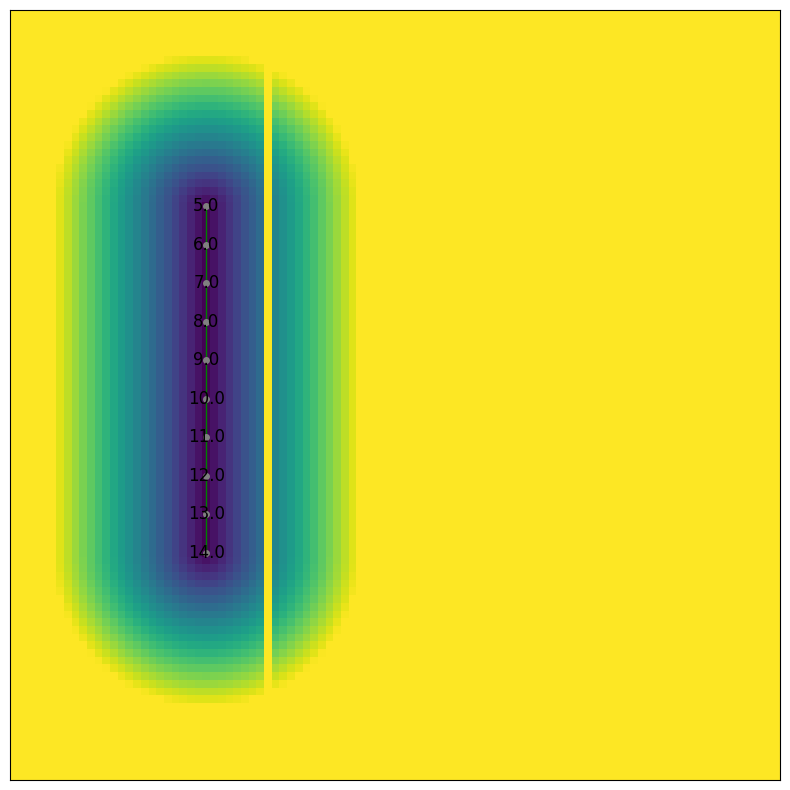

In [194]:
show(np.array(pss), "", g)

C:\Users\serta\AppData\Local\Temp\ipykernel_13332\120819112.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect.detach()), "",g)


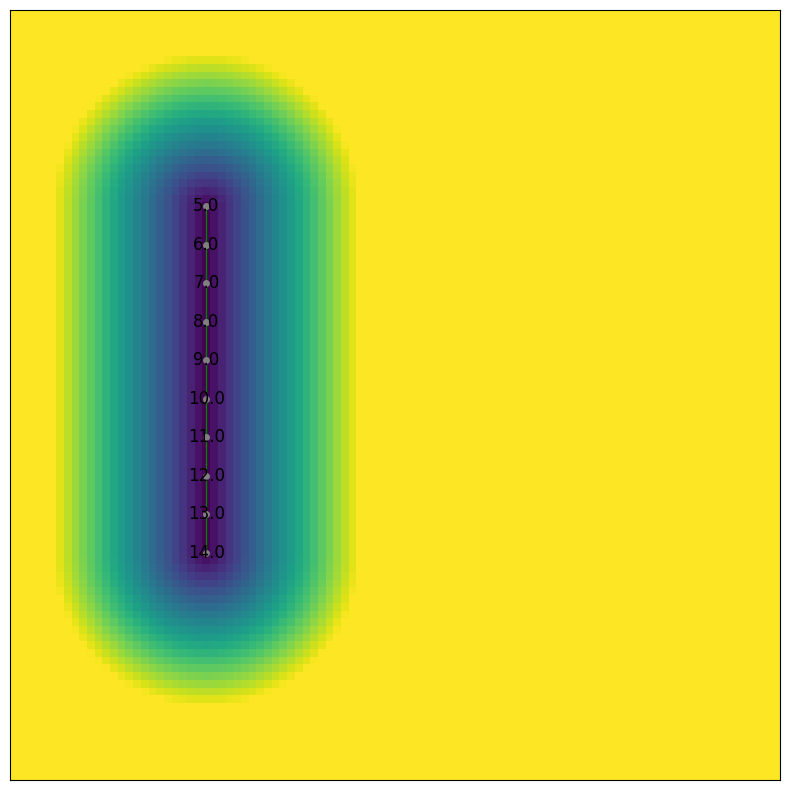

C:\Users\serta\AppData\Local\Temp\ipykernel_13332\120819112.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_initial2[0][0].detach()), "", g)


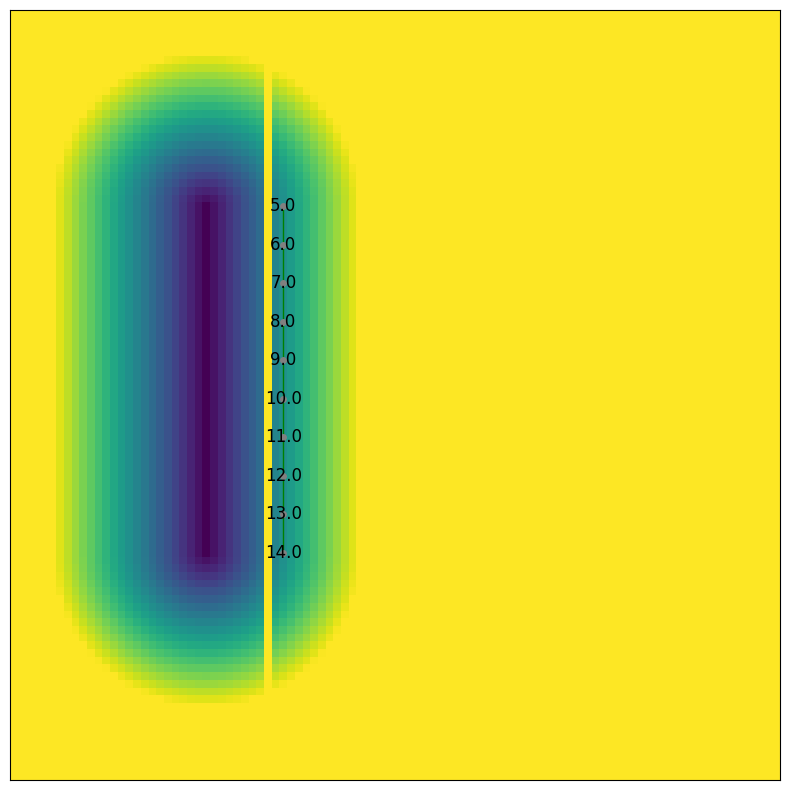

C:\Users\serta\AppData\Local\Temp\ipykernel_13332\120819112.py:56: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())


Iteration 0, Loss: 20.320697784423828


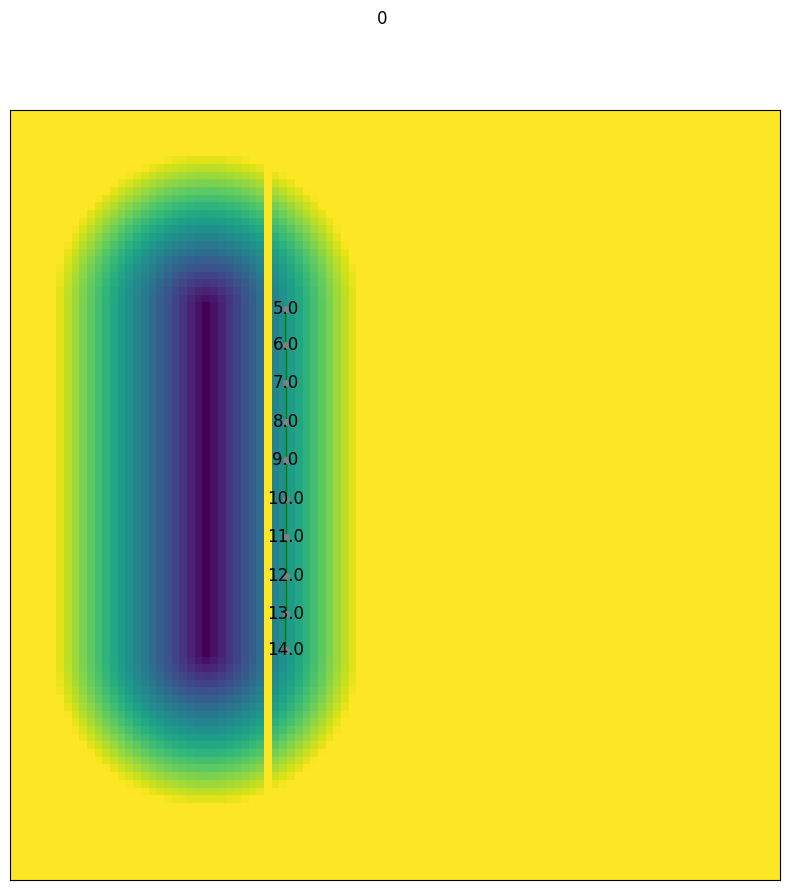

Iteration 10, Loss: 20.260038375854492
Iteration 20, Loss: 20.199565887451172
Iteration 30, Loss: 20.1392765045166
Iteration 40, Loss: 20.07916831970215
Iteration 50, Loss: 20.019241333007812
Iteration 60, Loss: 19.959501266479492
Iteration 70, Loss: 19.899940490722656
Iteration 80, Loss: 19.840551376342773
Iteration 90, Loss: 19.781341552734375
Iteration 100, Loss: 19.722309112548828
Iteration 110, Loss: 19.663454055786133
Iteration 120, Loss: 19.604778289794922
Iteration 130, Loss: 19.54627799987793
Iteration 140, Loss: 19.487958908081055
Iteration 150, Loss: 19.4298095703125
Iteration 160, Loss: 19.371837615966797
Iteration 170, Loss: 19.314044952392578
Iteration 180, Loss: 19.25642204284668
Iteration 190, Loss: 19.198974609375
Iteration 200, Loss: 19.14170265197754
Iteration 210, Loss: 19.084609985351562
Iteration 220, Loss: 19.027677536010742
Iteration 230, Loss: 18.970918655395508
Iteration 240, Loss: 18.91434097290039
Iteration 250, Loss: 18.857929229736328
Iteration 260, Loss: 

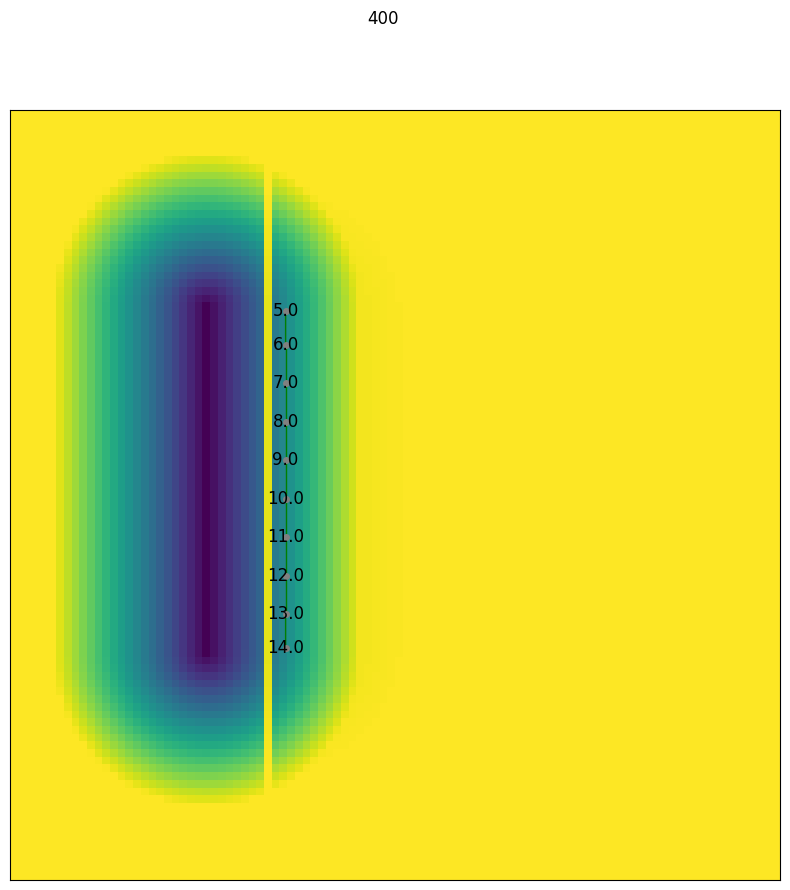

Iteration 410, Loss: 17.978153228759766
Iteration 420, Loss: 17.92456817626953
Iteration 430, Loss: 17.871137619018555
Iteration 440, Loss: 17.817880630493164
Iteration 450, Loss: 17.764774322509766
Iteration 460, Loss: 17.711833953857422
Iteration 470, Loss: 17.659059524536133
Iteration 480, Loss: 17.60643196105957
Iteration 490, Loss: 17.553974151611328
Iteration 500, Loss: 17.501665115356445
Iteration 510, Loss: 17.449522018432617
Iteration 520, Loss: 17.397533416748047
Iteration 530, Loss: 17.3456974029541
Iteration 540, Loss: 17.29401969909668
Iteration 550, Loss: 17.242496490478516
Iteration 560, Loss: 17.19112777709961
Iteration 570, Loss: 17.139902114868164
Iteration 580, Loss: 17.08884620666504
Iteration 590, Loss: 17.037940979003906
Iteration 600, Loss: 16.987180709838867
Iteration 610, Loss: 16.93657112121582
Iteration 620, Loss: 16.886117935180664
Iteration 630, Loss: 16.835811614990234
Iteration 640, Loss: 16.7856502532959
Iteration 650, Loss: 16.735647201538086
Iteration 

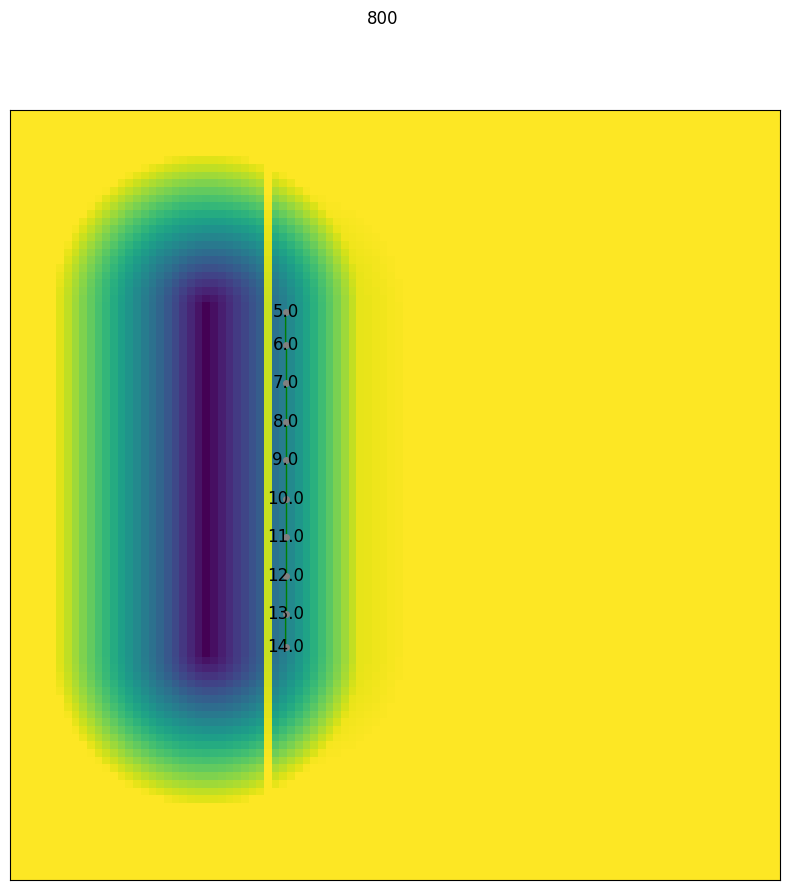

Iteration 810, Loss: 15.955537796020508
Iteration 820, Loss: 15.908019065856934
Iteration 830, Loss: 15.86064338684082
Iteration 840, Loss: 15.81341552734375
Iteration 850, Loss: 15.76632308959961
Iteration 860, Loss: 15.719378471374512
Iteration 870, Loss: 15.672572135925293
Iteration 880, Loss: 15.625907897949219
Iteration 890, Loss: 15.579380989074707
Iteration 900, Loss: 15.533001899719238
Iteration 910, Loss: 15.486756324768066
Iteration 920, Loss: 15.440648078918457
Iteration 930, Loss: 15.394684791564941
Iteration 940, Loss: 15.348855972290039
Iteration 950, Loss: 15.303165435791016
Iteration 960, Loss: 15.257612228393555
Iteration 970, Loss: 15.212200164794922
Iteration 980, Loss: 15.166921615600586
Iteration 990, Loss: 15.12177848815918
Iteration 1000, Loss: 15.076774597167969
Iteration 1010, Loss: 15.031903266906738
Iteration 1020, Loss: 14.987168312072754
Iteration 1030, Loss: 14.9425687789917
Iteration 1040, Loss: 14.898099899291992
Iteration 1050, Loss: 14.853768348693848


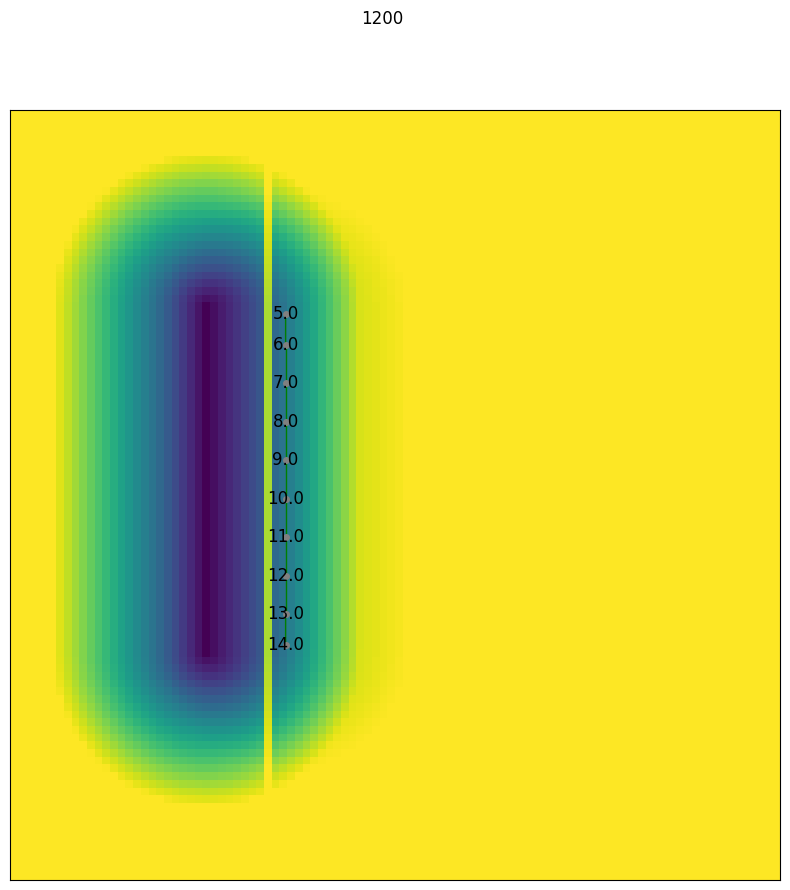

Iteration 1210, Loss: 14.162168502807617
Iteration 1220, Loss: 14.120037078857422
Iteration 1230, Loss: 14.078032493591309
Iteration 1240, Loss: 14.036151885986328
Iteration 1250, Loss: 13.99439811706543
Iteration 1260, Loss: 13.952770233154297
Iteration 1270, Loss: 13.91126537322998
Iteration 1280, Loss: 13.869881629943848
Iteration 1290, Loss: 13.828628540039062
Iteration 1300, Loss: 13.787495613098145
Iteration 1310, Loss: 13.746482849121094
Iteration 1320, Loss: 13.705609321594238
Iteration 1330, Loss: 13.664831161499023
Iteration 1340, Loss: 13.624194145202637
Iteration 1350, Loss: 13.58366584777832
Iteration 1360, Loss: 13.543279647827148
Iteration 1370, Loss: 13.50299072265625
Iteration 1380, Loss: 13.462836265563965
Iteration 1390, Loss: 13.422797203063965
Iteration 1400, Loss: 13.3828706741333
Iteration 1410, Loss: 13.343076705932617
Iteration 1420, Loss: 13.303400039672852
Iteration 1430, Loss: 13.263853073120117
Iteration 1440, Loss: 13.224404335021973
Iteration 1450, Loss: 

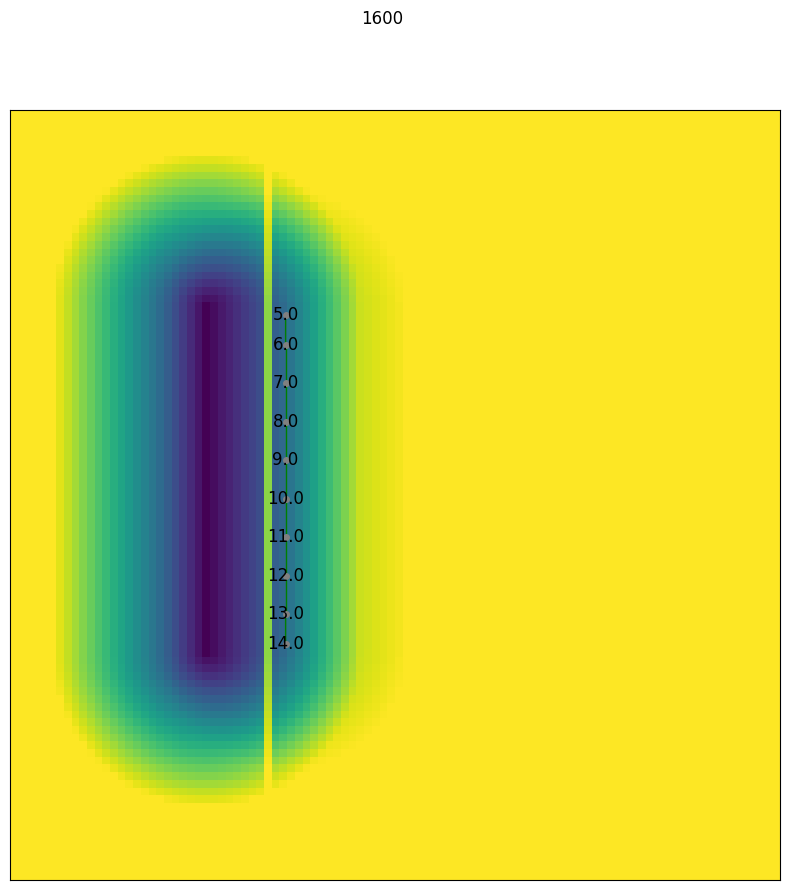

Iteration 1610, Loss: 12.571917533874512
Iteration 1620, Loss: 12.534566879272461
Iteration 1630, Loss: 12.497333526611328
Iteration 1640, Loss: 12.460214614868164
Iteration 1650, Loss: 12.423203468322754
Iteration 1660, Loss: 12.38630485534668
Iteration 1670, Loss: 12.349519729614258
Iteration 1680, Loss: 12.312843322753906
Iteration 1690, Loss: 12.276278495788574
Iteration 1700, Loss: 12.239829063415527
Iteration 1710, Loss: 12.203486442565918
Iteration 1720, Loss: 12.167253494262695
Iteration 1730, Loss: 12.13113021850586
Iteration 1740, Loss: 12.095114707946777
Iteration 1750, Loss: 12.059205055236816
Iteration 1760, Loss: 12.023399353027344
Iteration 1770, Loss: 11.987706184387207
Iteration 1780, Loss: 11.952118873596191
Iteration 1790, Loss: 11.91663932800293
Iteration 1800, Loss: 11.881265640258789
Iteration 1810, Loss: 11.846001625061035
Iteration 1820, Loss: 11.810840606689453
Iteration 1830, Loss: 11.775786399841309
Iteration 1840, Loss: 11.740837097167969
Iteration 1850, Los

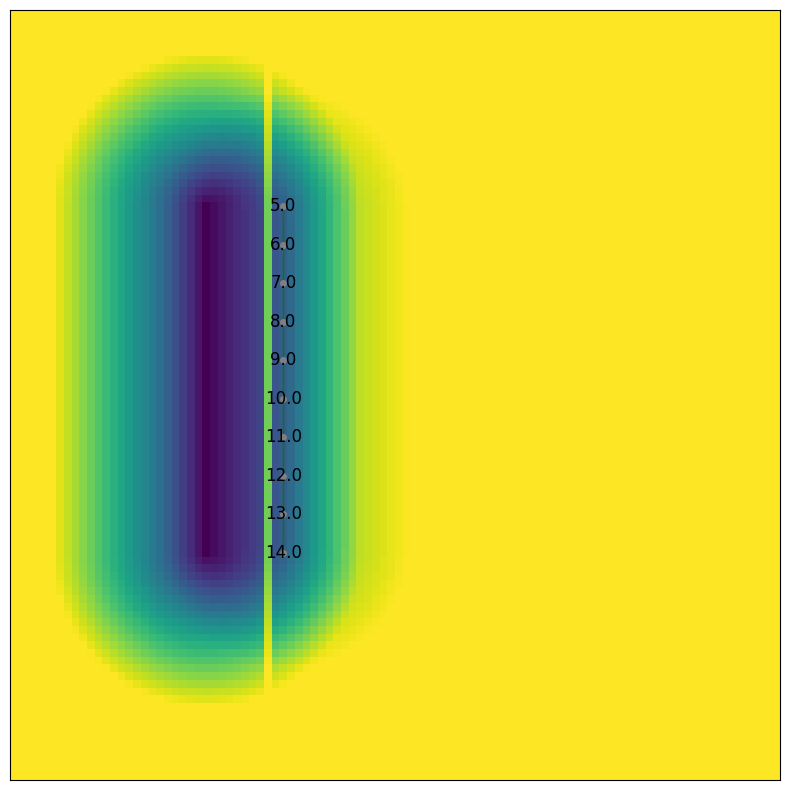

C:\Users\serta\AppData\Local\Temp\ipykernel_13332\120819112.py:63: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(final_pred[0][0]), "",loss.snake.getGraph())


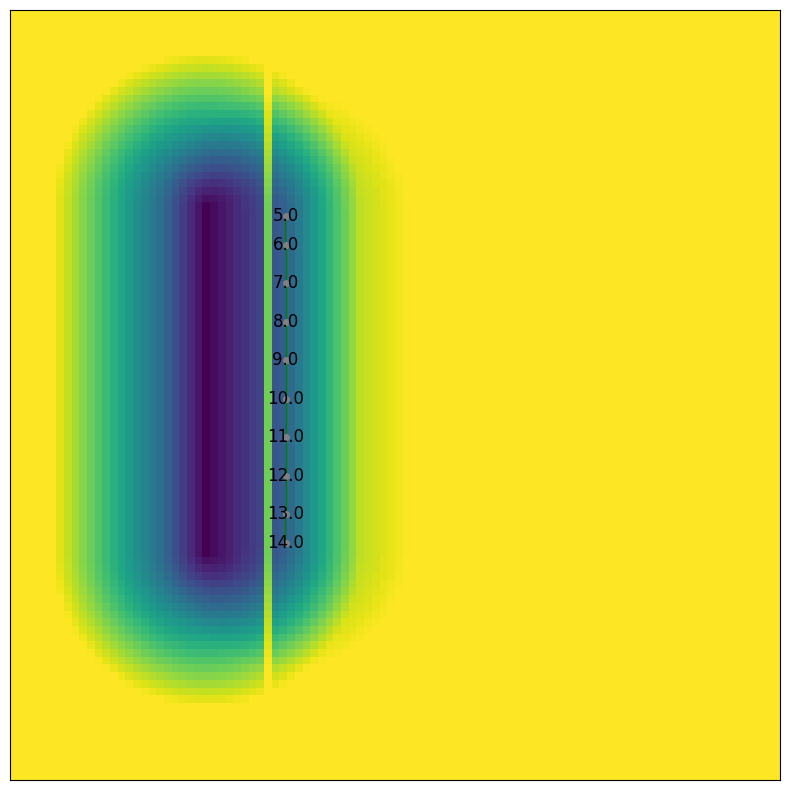

In [198]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims =2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect.detach()), "",g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34] = 16.0

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2 = nn.Parameter(pred_initial2.clone(), requires_grad=True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10]) 

show(np.array(pred_initial2[0][0].detach()), "", g)

fltrstdev=1.0

opt = optim.SGD([pred2], lr=0.75, momentum=0.0)

extgradfac=1.0
nsteps=60
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                crop,16,4,extgradfac)

for i in range(2000):
    opt.zero_grad()
    loss_val = loss.forward(pred2, [g], ind=i)
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 400 == 0:
        show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())

show(pred2.detach().cpu().numpy()[0, 0], "",g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(np.array(final_pred[0][0]), "",loss.snake.getGraph())

In [ ]:
loss.snake.get_w()

tensor([-0.1390, -0.1510, -0.0563,  0.0234,  0.0906,  0.1075,  0.0899,  0.0079,
        -0.0637, -0.0723])

------------------

C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3833761391.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tangents_tensor = torch.tensor(tangents, dtype=torch.float32, device=device)
C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3954249983.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(ddd), g)


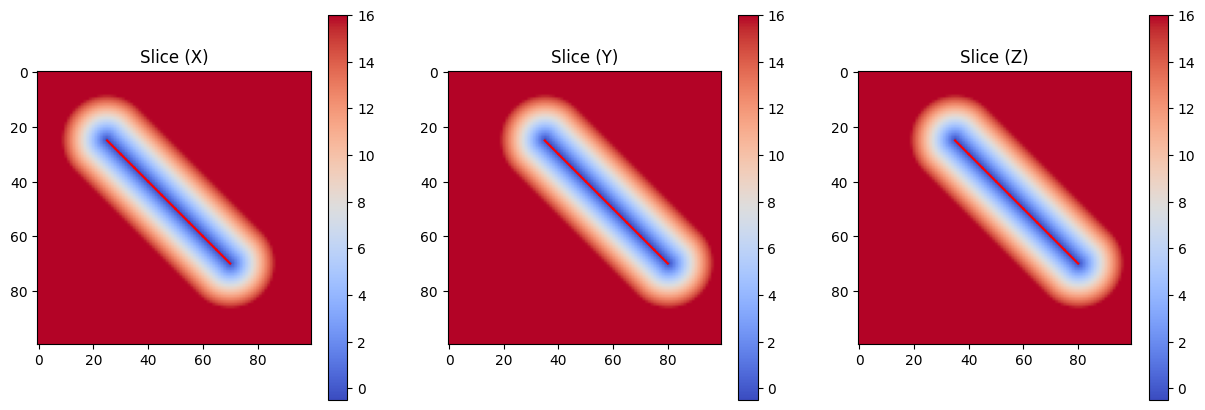

In [15]:
sa = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=3)
ddd = sa.render_distance_map((100,100,100))
show_slices(np.array(ddd), g)

In [ ]:
widths = th.tensor([5.0]*50,dtype=th.float32)
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf.detach().cpu(), dtype=np.float32)
tangents = np.array([tangent.detach().cpu().numpy() for tangent in tangents])

def create_circle(center, tangent, radius, normal, num_points=50):
    u = np.cross(tangent, normal)
    u = u / np.linalg.norm(u)    

    angles = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.array([center + radius * (np.cos(a) * u + np.sin(a) * normal)
                              for a in angles])
    return circle_points

circles = []
num_centers = len(centers)

for i in range(num_centers):
    center = centers[i]
    radius = widths[i]
    tangent = tangents[i]
    normal = normals[i]
    
    circle = create_circle(center, tangent, radius, normal)
    circles.append(circle)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2522089646.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf.detach().cpu(), dtype=np.float32)


In [68]:
params = calculate_grid_parameters(centers, widths, padding=10, voxel_resolution=1.0)

In [71]:
distance_map = compute_3d_distance_map(
    centers, widths, tangents, 
    grid_shape=params['grid_shape'],
    voxel_size=params['voxel_size'],
    origin=params['origin']
)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


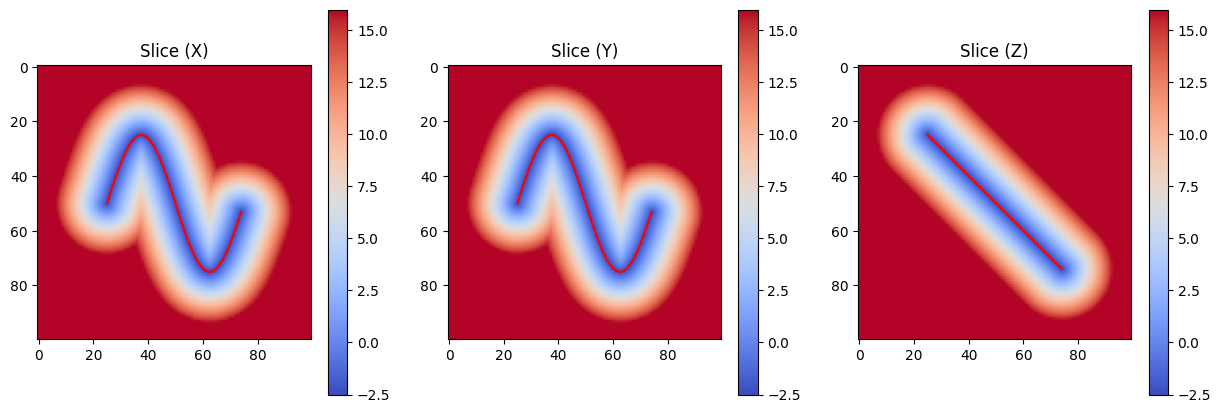

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


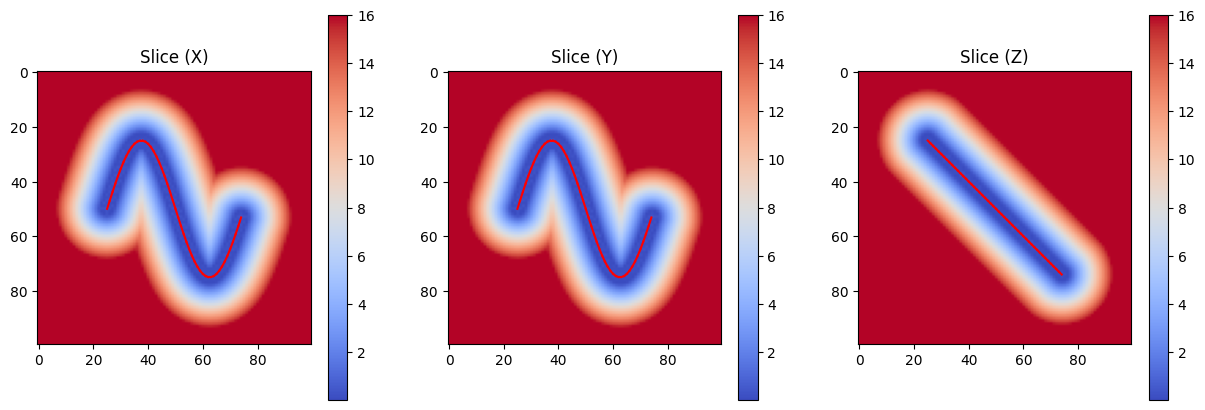

In [72]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


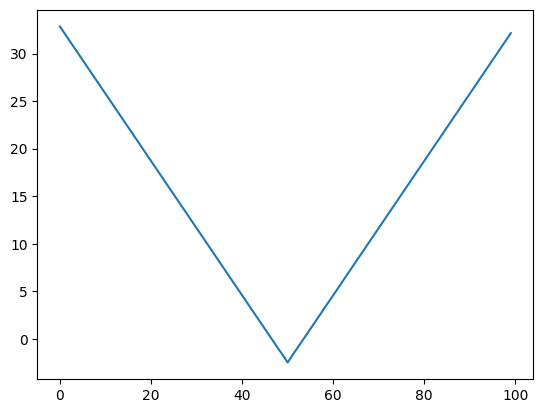

In [73]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [74]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


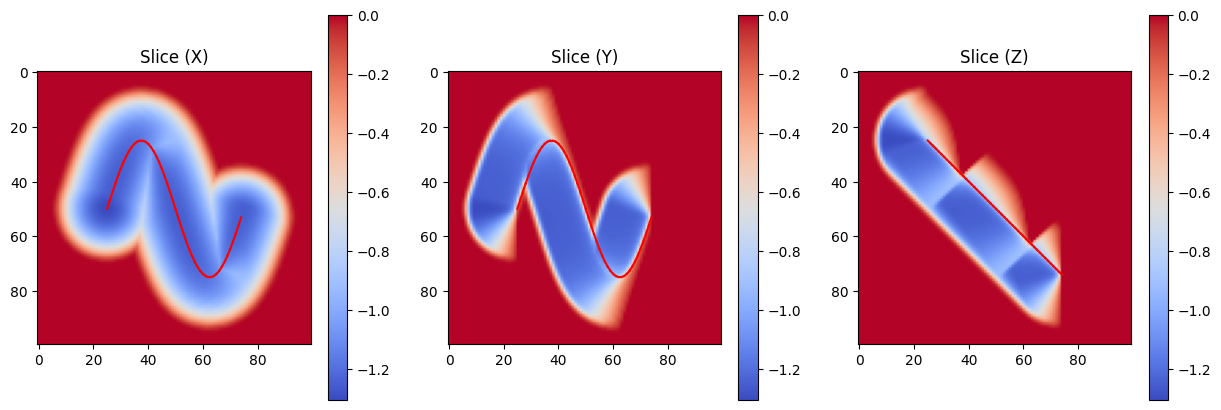

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


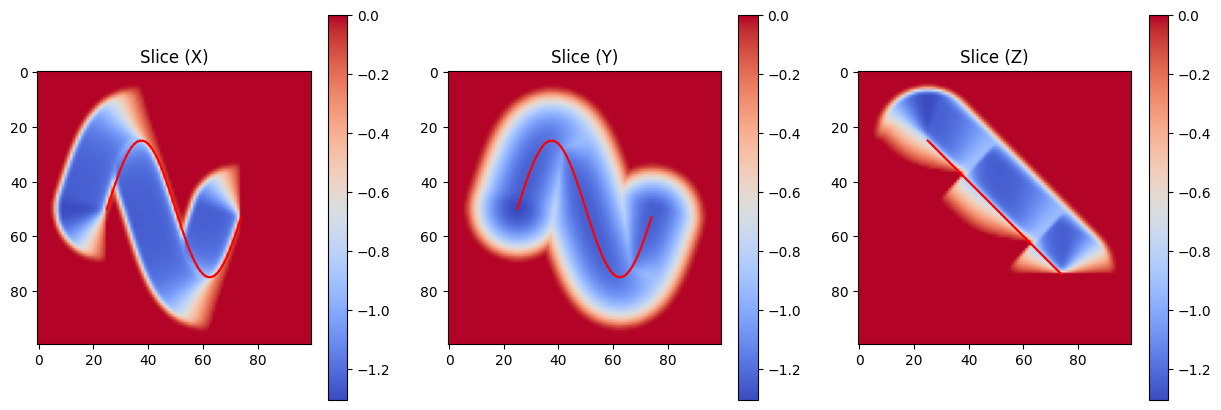

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


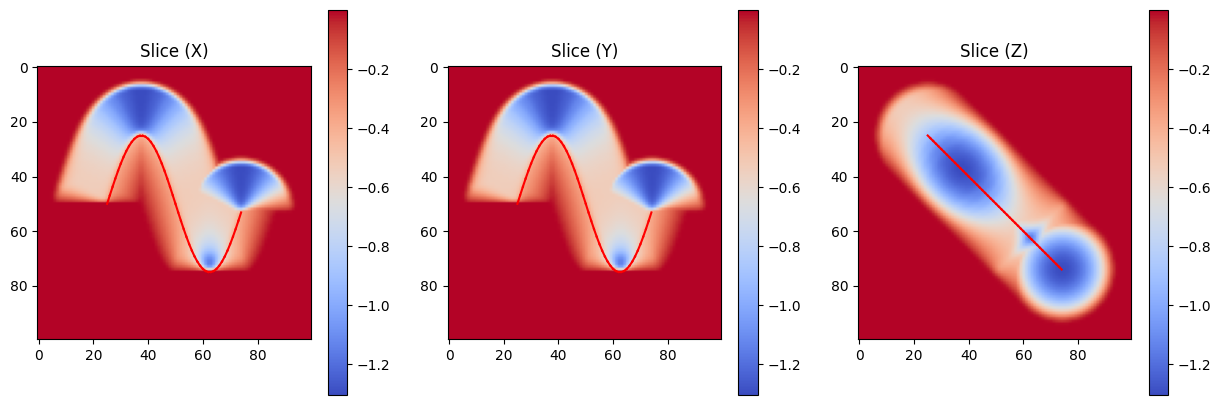

In [75]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [76]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,4,0])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1906394730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


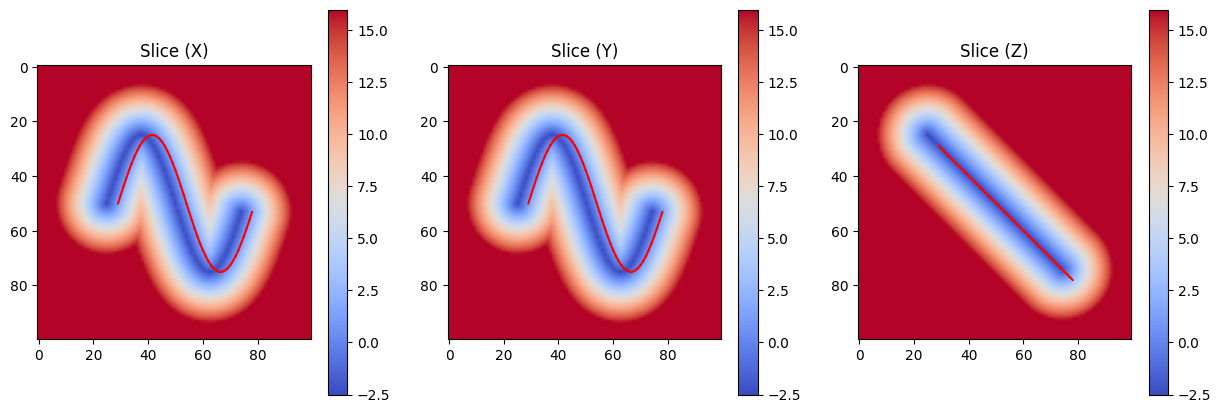

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1906394730.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


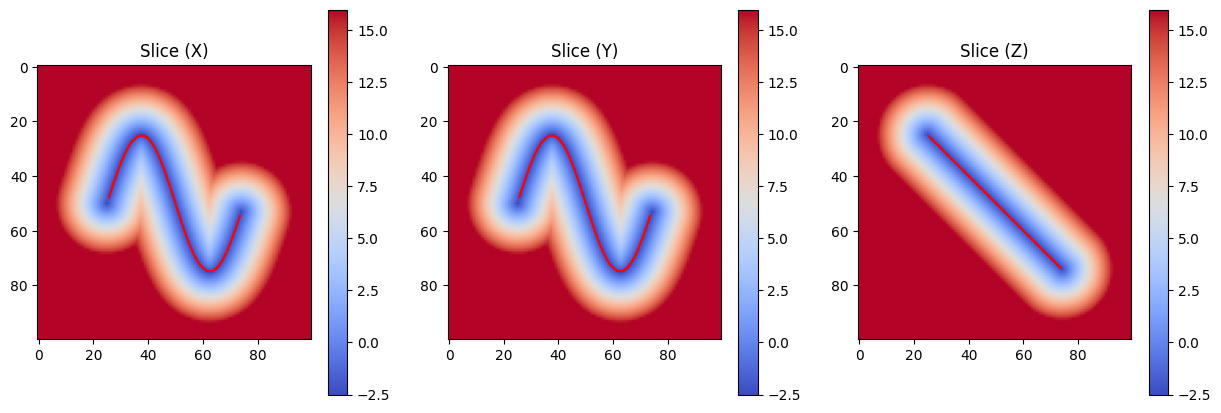

In [77]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgv, gimgw, step_type="original", ndims=3)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
print(sa.get_w())
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [78]:
sa.get_w()

tensor([[2.4538],
        [3.9162],
        [4.3532],
        [4.3865],
        [4.3939],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3925],
        [4.3805],
        [4.3759],
        [4.3742],
        [4.3743],
        [4.3731],
        [4.3730],
        [4.3767],
        [4.3846],
        [4.3891],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3945],
        [4.3805],
        [4.3521],
        [3.9377],
        [2.4836]], device='cuda:0')

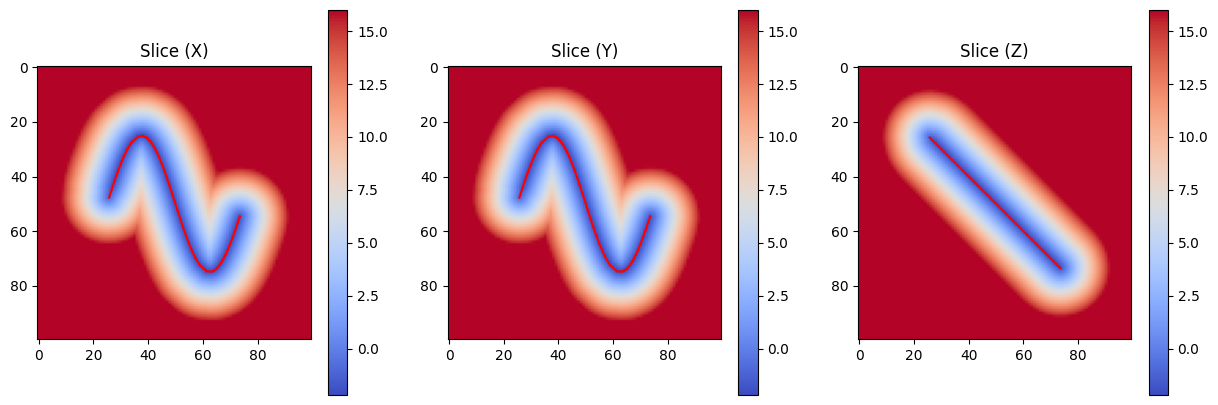

In [82]:
show_slices(sa.render_distance_map((100,100,100)).detach().cpu().numpy(), sa.getGraph()) 

In [87]:
newd = sa.render_distance_map((100,100,100)).detach().cpu().numpy()
diff = newd - predv.detach().cpu().numpy()[0][0]

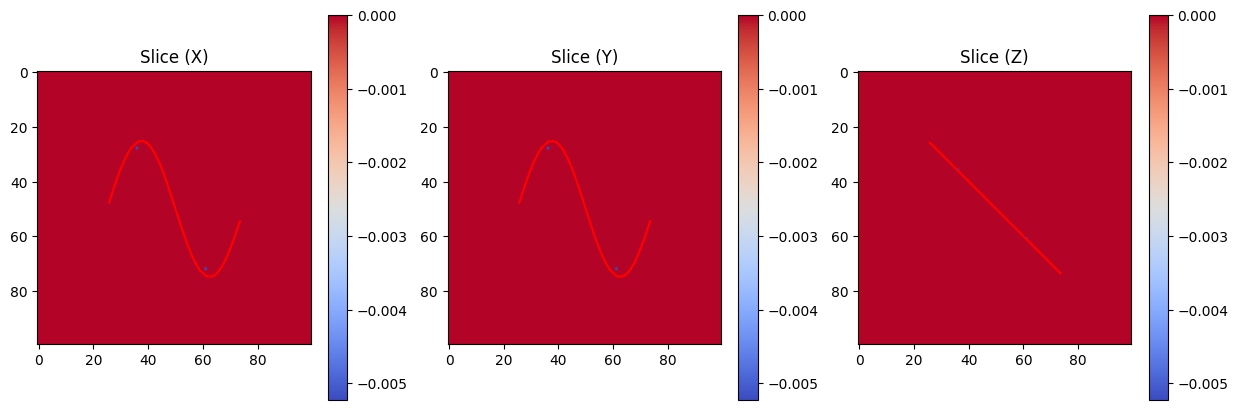

In [88]:
show_slices(diff, sa.getGraph())